# Letal COVID-19 snRNA Analysis
# Section 3: Feature Selection
Author: MikiasHWT  
Start: December 9, 2024  

In [204]:
from datetime import datetime
current_date = datetime.now().strftime("%B %d, %Y")
print(f"Updated: {current_date}")

Updated: December 20, 2024


# Background

Much of RNA sequencing data is actually quite uninformative in nature. Many genes are comparably expressed between many cell types under homeostatic conditions, these housekeeping genes do not add value to a final analysis (although they can provide a lot of benefit for quality assesement). Additionally most RNA sequencing experiments are targetted at specific tissues or cell types, meaning that certain gene signatures provide little insight of value. In a perfect world where computational costs were not a consideration, it may be interested to use all 20-30,000 genes of a typical single cell experiment for downstream analysis, but in reality this is not feasable when a single sample can contain thousands of cells with many samples in an experiment. 

Therefor it is standard practice to subset our genes for the most variably expressed genes. Not simply for the genes that are highly expressed, as this could include housekeeping genes like Beta Acting and GAPDH, but genes that have a high degree of variablity between cell types. These genes are generally considered to be the informative signatures worth keeping for downstream analysis. 

Once again, various methods exist for applying this selection criteria. 

## Objective

- Explore various method to select features
- Determine Highly Informative Genes Substs

# Prep Workspace

## Import Libraries

In [205]:
# Default 
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization
import scanpy as sc  # Single-cell data analysis
from scipy.sparse import issparse, csr_matrix  # For sparse matrix handling
import os  # Operating system interface

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [206]:
# R Functionality & warnings
import warnings  
import anndata2ri  # For AnnData & Single Cell Experiment Compatibility
import logging  
import rpy2.rinterface_lib.callbacks as rcb  # For managing R callback messages
import rpy2.robjects as ro  # Core rpy2 object for interacting with R

# Activate pandas2ri and anndata2ri converters
from rpy2.robjects import pandas2ri
pandas2ri.activate()  # Converting pandas df's between Python and R
anndata2ri.activate()  # Converting AnnData objects between Python and R

ro.r('options(device="windows")')  # Ensures compatibility for plotting on Windows

rcb.logger.setLevel(logging.ERROR)  # Suppres rpy2 logging messages

warnings.simplefilter("ignore", category=DeprecationWarning) # Suppress warnings
warnings.simplefilter('ignore', category=FutureWarning) # ''

# Load the rpy2 IPython magic
%load_ext rpy2.ipython 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [207]:
# For Data visualization
from matplotlib_venn import venn3 # Venn diagram
from upsetplot import UpSet # Upset plots

In [208]:
%%R
# Load R package
library(scry)

## Define Functions

In [209]:
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'outlier_temp_colors', 'hvg'
    layers: 'counts', 'log1p-CP10K', 'log1p-CPM', 'log1p-median', 'pearson_residuals', 'scran_normalization'

In [210]:
# Define function to plot mean by dispersion and color by highly variable genes. Mark a subset of cells for comparison across methods. 
def plot_highly_variable_genes_single(data, x, y, title="Highly Variable Genes"):
    """
    Plots a scatter plot of highly variable genes with highlighted markers.
    
    Parameters:
    - data (DataFrame): DataFrame containing gene statistics (genes, means, dispersion, highly_variable).
    - x (str): Column name for the x-axis (e.g., "means").
    - y (str): Column name for the y-axis (e.g., "dispersions").
    - title (str): Title of the plot.
    """
    # Extract data
    x_vals = data[x]
    y_vals = data[y]
    highly_variable = data["highly_variable"]

    # scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_vals, y_vals, c=highly_variable, cmap="coolwarm", s=10)

    # Label marker genes
    for gene in markers:
        if gene in data.index:
            row = data.loc[gene]
            plt.scatter(row[x], row[y], color="white", edgecolor="black", s=50)
            plt.text(row[x], row[y], gene, fontsize=15, ha="right", color="black")

    # Add Value counts
    summary = data["highly_variable"].value_counts()
    plt.text(
        0.95, 0.05, 
        f"Highly Variable: {summary.get(True, 0)}\nNot Variable: {summary.get(False, 0)}",
        transform=plt.gca().transAxes, 
        fontsize=15, ha="right", 
        bbox=dict(facecolor="white", alpha=0.7)
    )

    # Final plot touches
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(f"{x} (log scale)")
    plt.ylabel(f"{y} (log scale)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [211]:
# Visualize dispersion/variance as default and normalized
def plot_highly_variable_genes(data, x, y1, y2, title="Highly Variable Genes"):
    """
    Highly variable genes scatterplots. Define 2 y-axis variables for default and normalized dispersion/variance
    
    Parameters:
    - data (DataFrame): DataFrame containing gene statistics (genes, means, dispersion/variance, dispersions_norm/variance_norm, highly_variable).
    - x (str): Column name for the x-axis (e.g., "means").
    - y1 (str): Column name for the y-axis of the first plot.
    - y2 (str): Column name for the y-axis of the second plot.
    - title (str): Title for plots.
    """
    # Extract data
    x_vals = data[x]
    y1_vals = data[y1]
    y2_vals = data[y2]
    highly_variable = data["highly_variable"]

    # Adjecent plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
    
    # First plot
    axes[0].scatter(x_vals, y1_vals, c=highly_variable, cmap="coolwarm", s=10)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_title(f"{title}")
    axes[0].set_xlabel(f"{x} (log scale)")
    axes[0].set_ylabel(f"{y1} (log scale)")

    # Label markers plot 1
    for gene in markers:
        if gene in data.index:
            row = data.loc[gene]
            axes[0].scatter(row[x], row[y1], color="white", edgecolor="black", s=50)
            axes[0].text(row[x], row[y1], gene, fontsize=15, ha="right", color="black")

    # Second plot
    axes[1].scatter(x_vals, y2_vals, c=highly_variable, cmap="coolwarm", s=10)
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")
    axes[1].set_title("Alternate View")
    axes[1].set_xlabel(f"{x} (log scale)")
    axes[1].set_ylabel(f"{y2} (log scale)")

    # Label markers plot 2
    for gene in markers:
        if gene in data.index:
            row = data.loc[gene]
            axes[1].scatter(row[x], row[y2], color="white", edgecolor="black", s=50)
            axes[1].text(row[x], row[y2], gene, fontsize=15, ha="right", color="black")

    # Add Value counts
    summary = data["highly_variable"].value_counts()
    text = f"Highly Variable: {summary.get(True, 0)}\nNot Variable: {summary.get(False, 0)}"
    axes[0].text(0.95, 0.05, text, transform=axes[0].transAxes, fontsize=15, ha="right",
                 bbox=dict(facecolor="white", alpha=0.7))
    

    # Adjust layout
    plt.tight_layout()
    plt.show()


## Directories

In [212]:
# Define directories 
datDir = os.path.abspath("data")
outDir = os.path.abspath("output")

## Import Data

In [213]:
# Read single sample we QC'd & Normalized in previous sections
adata = sc.read_h5ad("data/C51ctr_Normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'outlier_temp_colors'
    layers: 'counts', 'log1p-CP10K', 'log1p-CPM', 'log1p-median', 'pearson_residuals', 'scran_normalization'

## Markers of Interest

In [214]:
# Common markers List to compare feature selection methods
markers = ["HLA-E", "CD4", "PTPRC", "IGHM", "ITGAX"]

# Scanpy Highly Variable Genes

Various alternate methods exists for feature selection. Each method has its pro's and con's, making it difficult to determine the optimal choice without a carefull consideration and a thourough exploration of the data and the scientific questions. We will explore Scanpy's various approached to feature selection and compare them by visualizing the "highly variable" cutoff and where a predefines list of common markers fall. 

Scanpy's `sc.pp.highly_variable_genes` utilized Seurats feature selection by default and expects log transformed values. When the flavor parameter is set to either `seurat_V3` or `seurat_V3_paper`, the function expects raw counts, which will be provided from the previously saved layer. 

Seurat modification [Comprehensive Integration of Single-Cell Data](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867419305598%3Fshowall%3Dtrue)


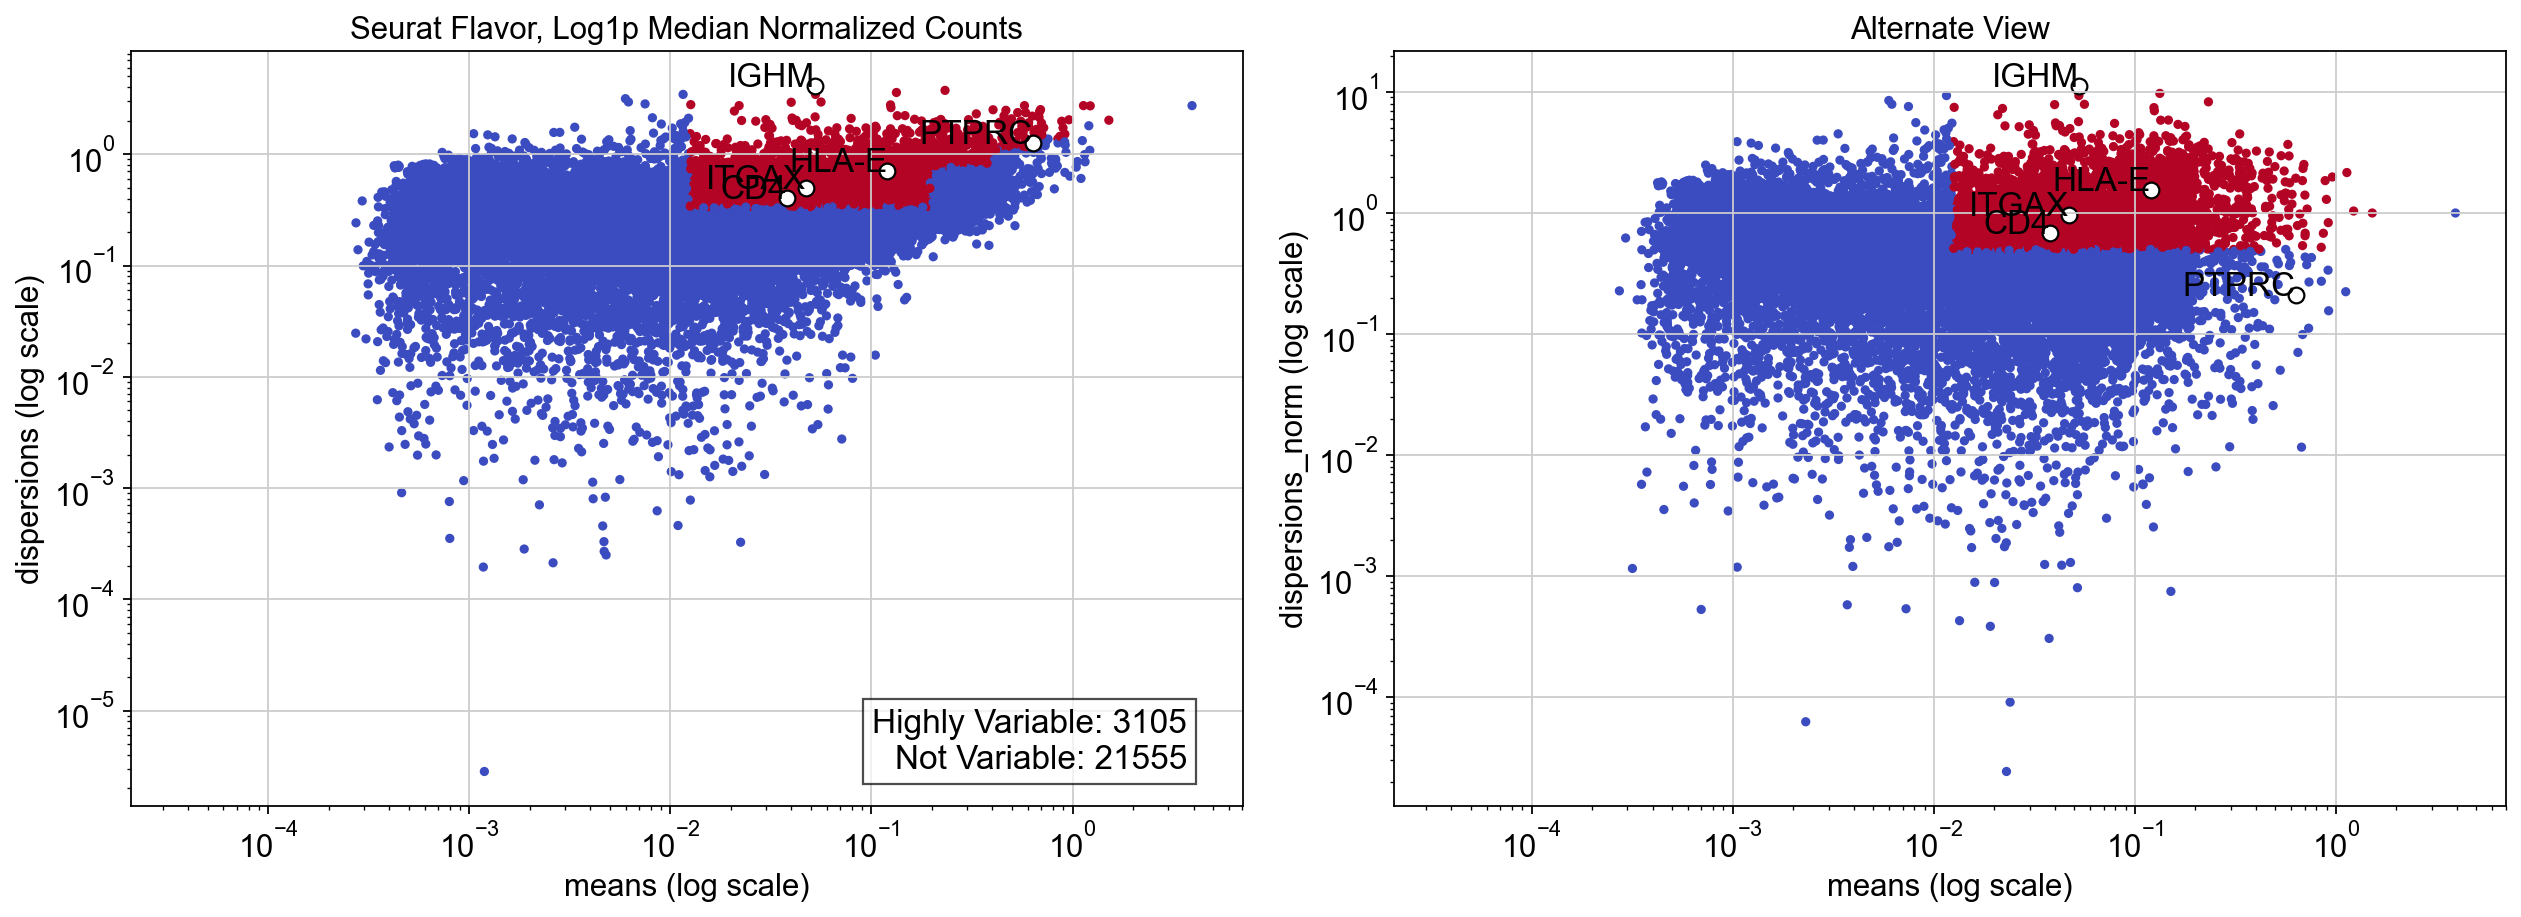

In [215]:
# Total counts normalized-pseudolog transformed layer, Seurat method
HVG_res_log1p_median = sc.pp.highly_variable_genes(adata, layer="log1p-median", inplace=False)

plot_highly_variable_genes(
    HVG_res_log1p_median,
    x="means",
    y1="dispersions",
    y2="dispersions_norm",
    title="Seurat Flavor, Log1p Median Normalized Counts")

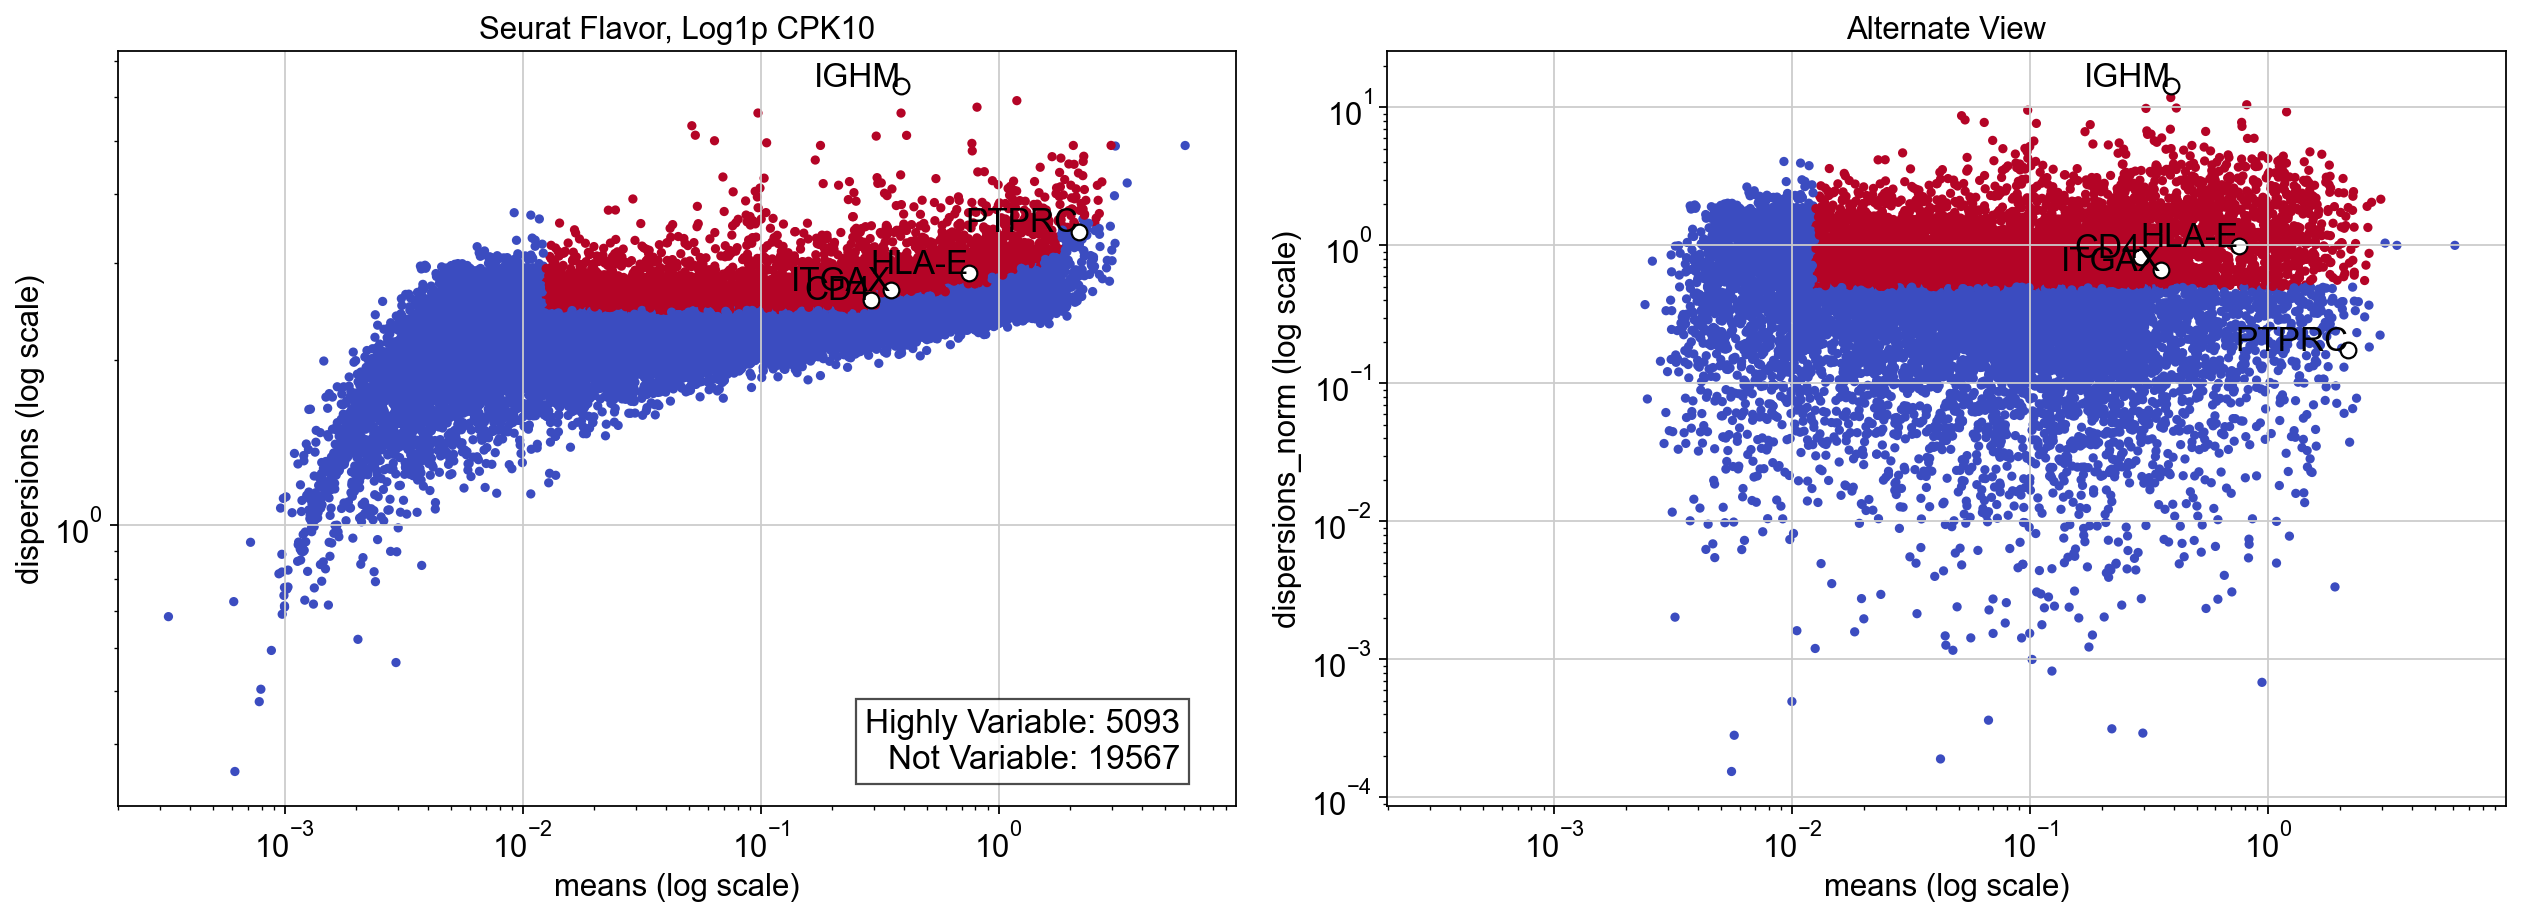

In [216]:
# CP10K normalized-pseudolog transformed layer, Seurat method
HVG_res_log1p_CP10K = sc.pp.highly_variable_genes(adata, layer="log1p-CP10K", inplace=False)

plot_highly_variable_genes(
    HVG_res_log1p_CP10K,
    x="means",
    y1="dispersions",
    y2="dispersions_norm",
    title="Seurat Flavor, Log1p CPK10")

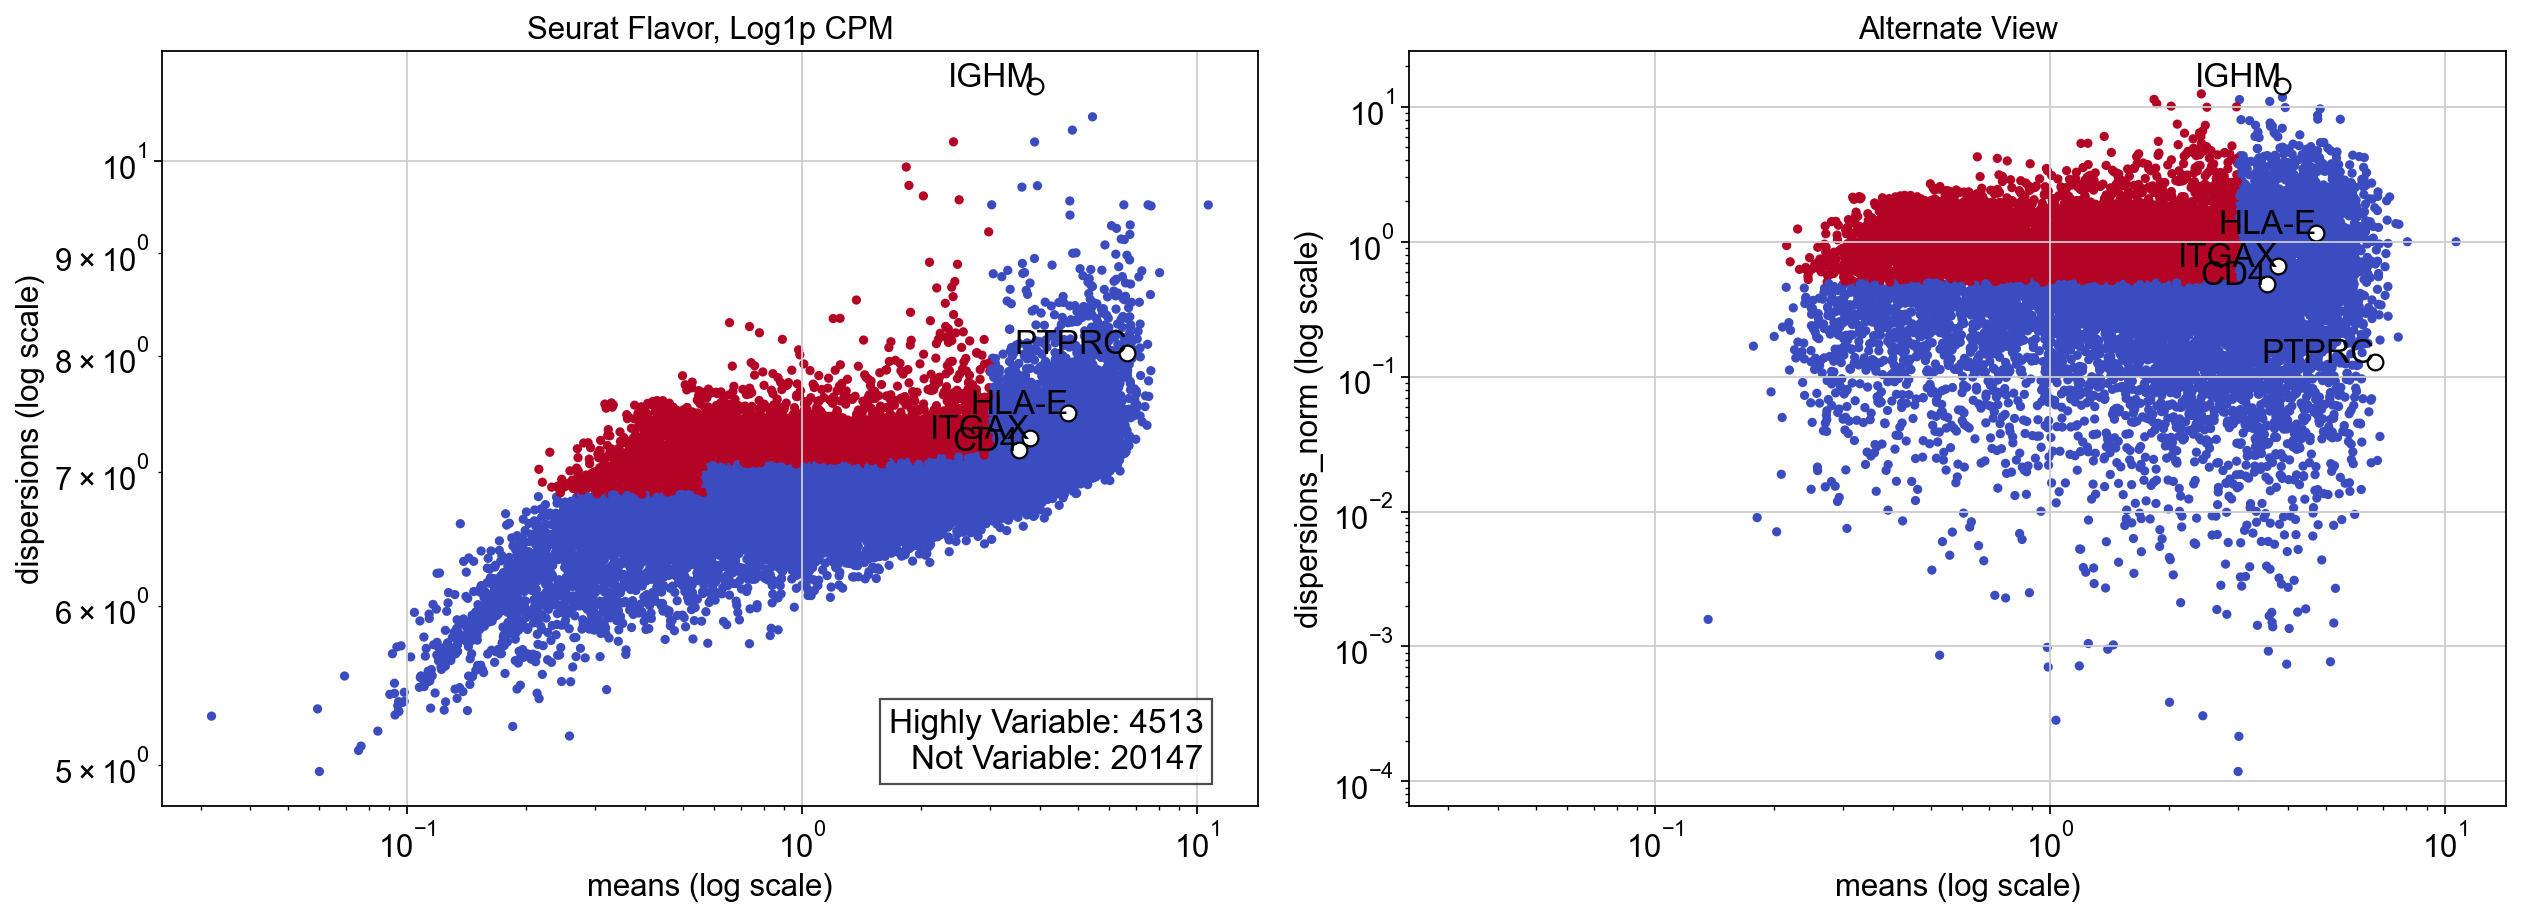

In [217]:
# CPM normalized-pseudolog transformed layer, Seurat method
HVG_res_log1p_CPM = sc.pp.highly_variable_genes(adata, layer="log1p-CPM", inplace=False)

plot_highly_variable_genes(
    HVG_res_log1p_CPM,
    x="means",
    y1="dispersions",
    y2="dispersions_norm",
    title="Seurat Flavor, Log1p CPM")

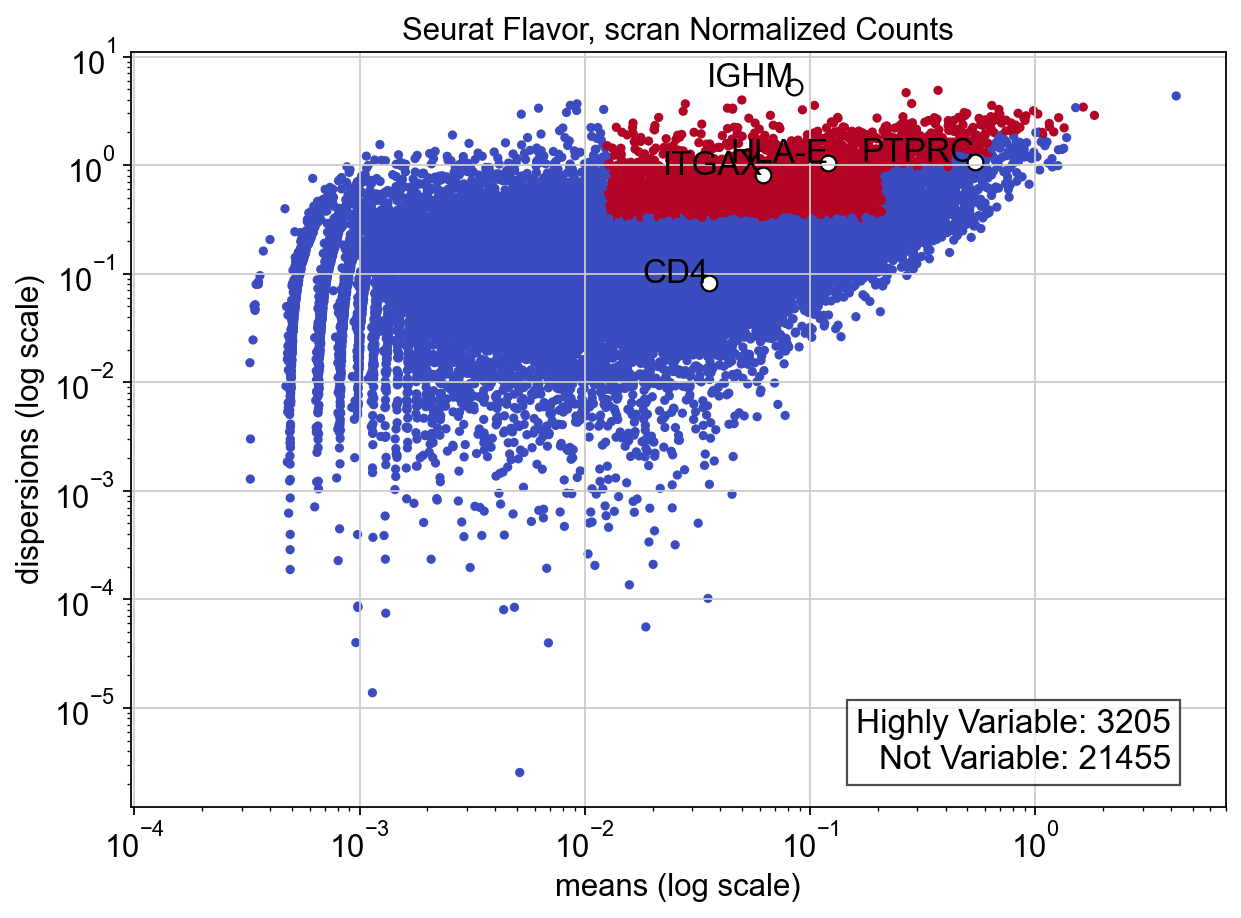

In [218]:
# Scran normalized layer, Seurat method
HVG_res_Scran = sc.pp.highly_variable_genes(adata, layer="scran_normalization", inplace=False)

plot_highly_variable_genes_single(HVG_res_Scran, "means", "dispersions", title="Seurat Flavor, scran Normalized Counts")

# plot_highly_variable_genes(
#     HVG_res_Scran,
#     x="means",
#     y1="dispersions",
#     y2="dispersions_norm",
#     title="Seurat Flavor, scran Normalized Counts")

In [219]:
# # Pearsons Residual transformed layer, Seurat method
# HVG_res_Pearsons_norm = sc.pp.highly_variable_genes(adata, layer="pearson_residuals", inplace=False)

# plot_highly_variable_genes(
#     HVG_res_Pearsons_norm,
#     x="means",
#     y1="dispersions",
#     y2="dispersions_norm",
#     title="Seurat Flavor, Pearson Residuals Normalized Counts");

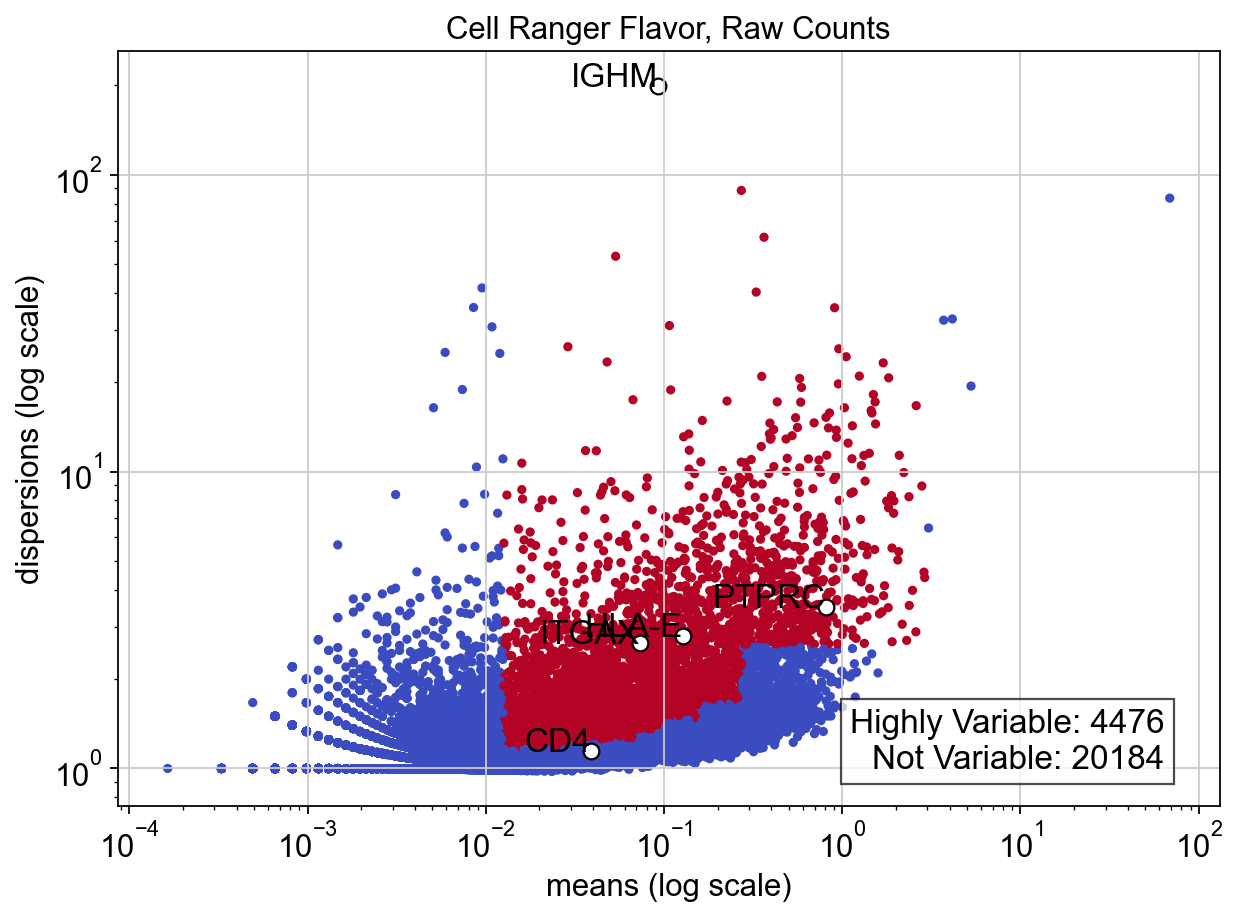

In [220]:
# Cell ranger method
HVG_res_Cell_Ranger = sc.pp.highly_variable_genes(adata, layer="counts", inplace=False, flavor='cell_ranger')

plot_highly_variable_genes_single(HVG_res_Cell_Ranger, "means", "dispersions", title="Cell Ranger Flavor, Raw Counts")

# plot_highly_variable_genes(
#     HVG_res_Cell_Ranger,
#     x="means",
#     y1="dispersions",
#     y2="dispersions_norm",
#     title="Cell Ranger Flavor, Raw Counts")

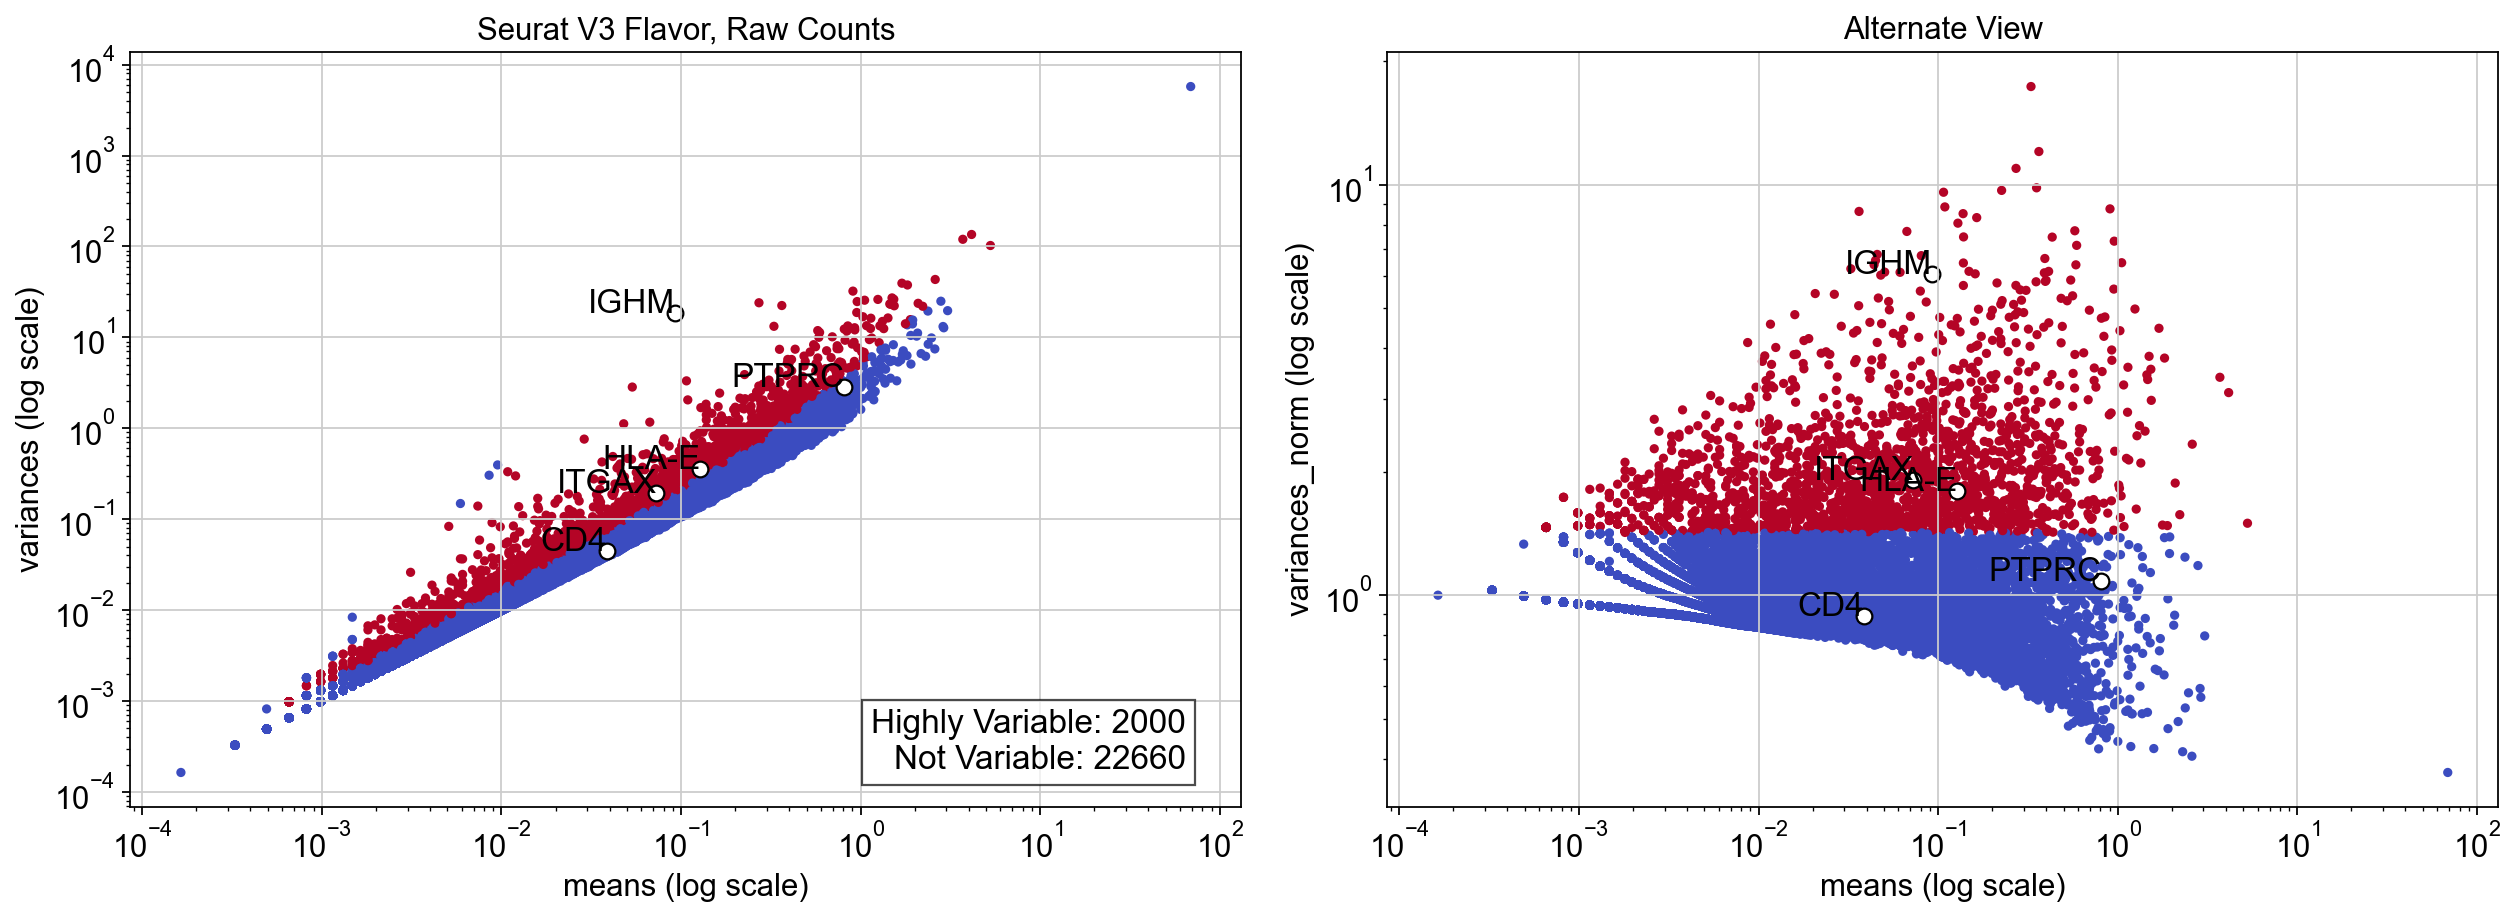

In [221]:
# Mimics Seurat’s FindVariableFeatures(…, method='mean.var.plot') &/or FindVariableFeatures(..., method='vst')
HVG_res_Seurat_v3 = sc.pp.highly_variable_genes(adata, layer="counts", inplace=False, flavor='seurat_v3')

plot_highly_variable_genes(
    HVG_res_Seurat_v3,
    x="means",
    y1="variances",
    y2="variances_norm",
    title="Seurat V3 Flavor, Raw Counts")

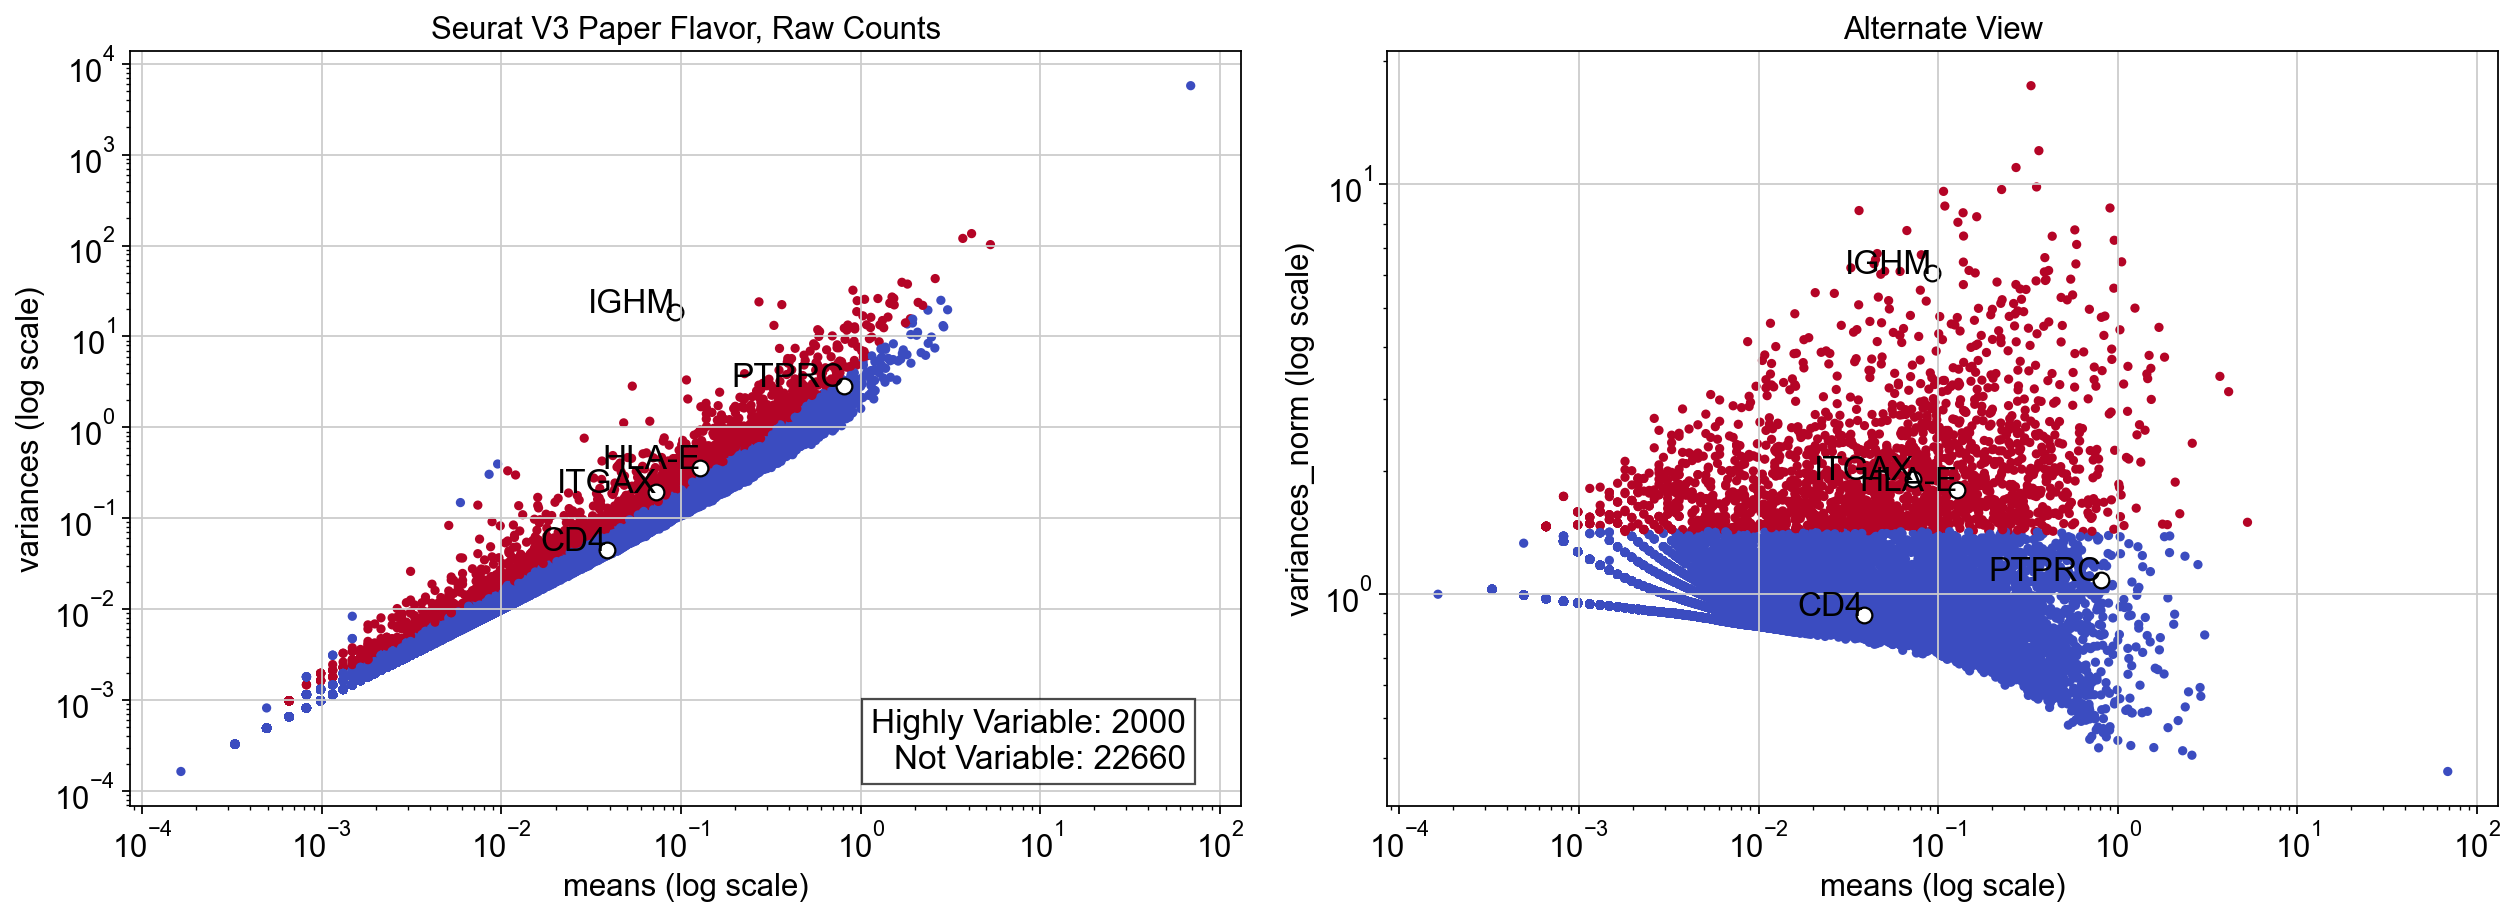

In [222]:
# Mimics Seurat’s FindVariableFeatures(…, method='mean.var.plot') &/or FindVariableFeatures(..., method='vst')
HVG_res_Seurat_V3_Paper = sc.pp.highly_variable_genes(adata, layer="counts", inplace=False, flavor='seurat_v3_paper')

plot_highly_variable_genes(
    HVG_res_Seurat_V3_Paper,
    x="means",
    y1="variances",
    y2="variances_norm",
    title="Seurat V3 Paper Flavor, Raw Counts")

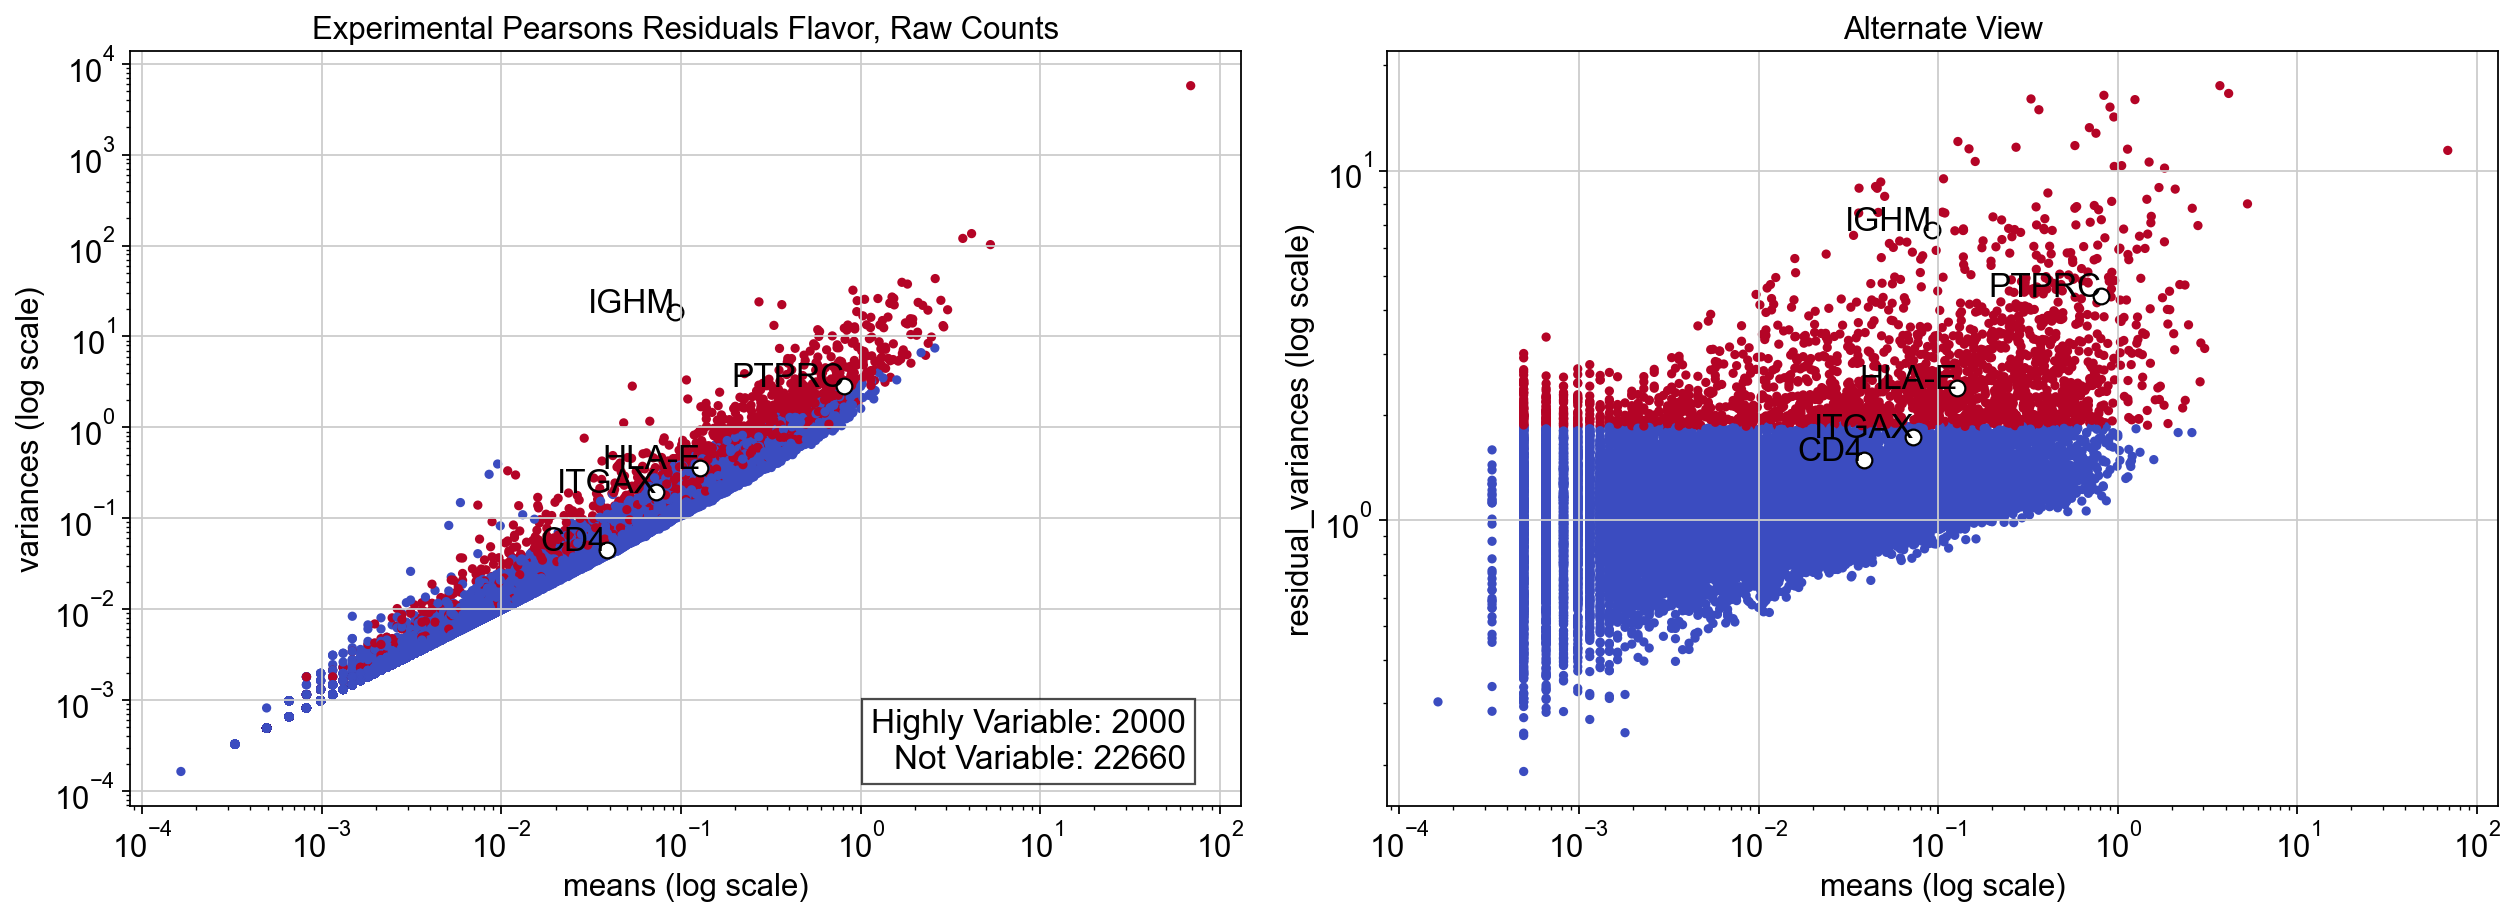

In [223]:
# Negative binomial (Experimental method)
HVG_res_Pearson_Expt = sc.experimental.pp.highly_variable_genes(adata, layer="counts", n_top_genes=2000, inplace=False, flavor='pearson_residuals')

plot_highly_variable_genes(
    HVG_res_Pearson_Expt,
    x="means",
    y1="variances",
    y2="residual_variances",
    title="Experimental Pearsons Residuals Flavor, Raw Counts")

Choosing the feature selection method will heavily indfluence the direction of the analysis. The choice i made to visualize a subset of markers could in theory be a problematic approach as it will influence my decision in which method to apply for feature selection. Consideration will given to this method of exploration in the future. 

For the time being, i will choose the method that includes my markers of interest in the highly variable category. 

Additionally i will choose the method that is permissive in its classification of highly variable genes. This will allow me a larger pool of genes for clustering and annontation, while still allowing me to reduce the number of dimensions with dimensionality reduction. 

# scry: Highly Deviant Genes

Starting with the assumption of contant expression across features, Bioconductor package scry ranks genes based on deviance if they deviate from their multinomial null model. The method works with raw count data.  

scry: Small-Count Analysis Methods for High-Dimensional Data. R package version 1.18.0 [Street K, Townes F, Risso D, Hicks S (2024)](https://bioconductor.org/packages/scry.html)

[Feature selection and dimension reduction for single-cell RNA-Seq based on a multinomial model](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6)

In [224]:
# Save Anndata to R envinronment
ro.globalenv["adata"] = adata

In [225]:
%%R
# Call deviance function on raw counts
sce = devianceFeatureSelection(adata, assay="X")

In [226]:
# Save binomial deviance (deviance ranking)
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [227]:
# Select top diviant genes as column in var
idx = binomial_deviance.argsort()[-3000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

# Use scanpy to compute mean and dispersion for visualization
sc.pp.highly_variable_genes(adata, layer="log1p-median")

In [228]:
# # Plot highly deviant genes
# ax = sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=15)
# ax.set_xlim(None, 1.5)
# ax.set_ylim(None, 5)
# plt.show();

Text(0.5, 1.0, 'Highly Deviant Genes, scry method')

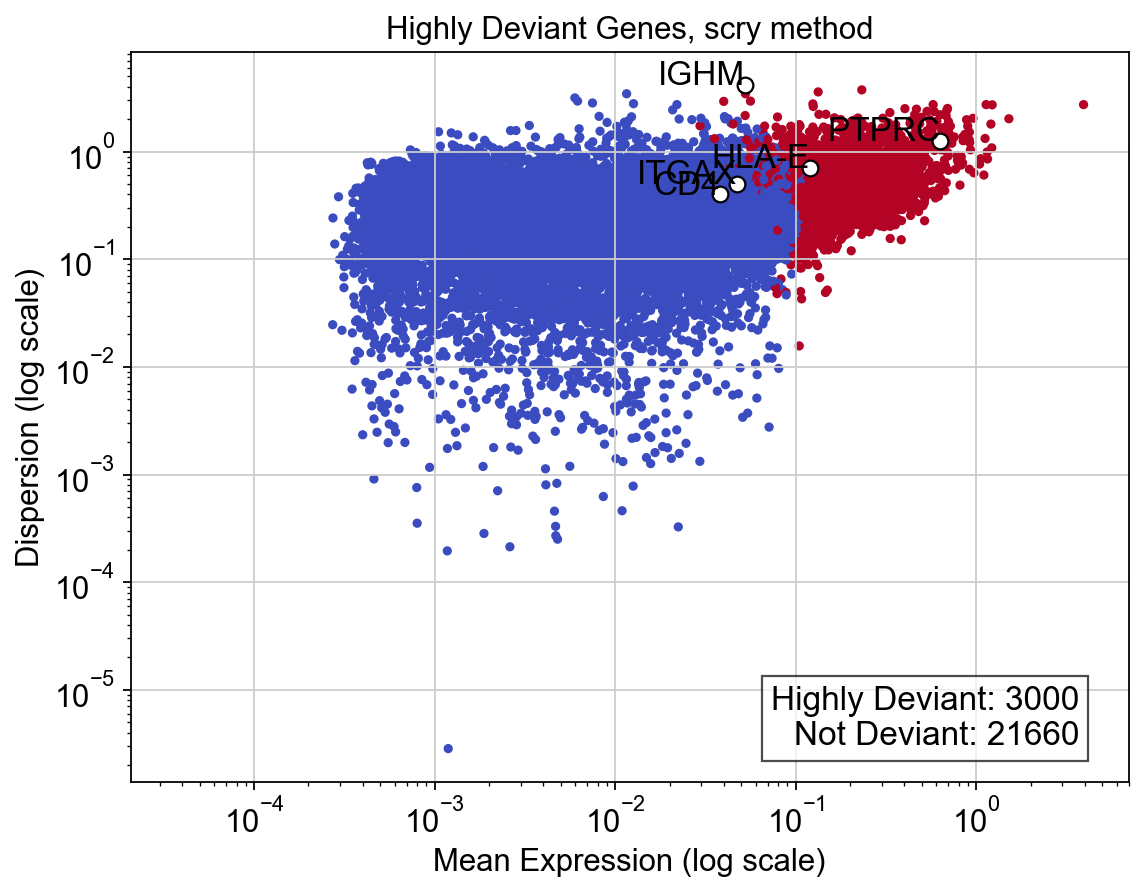

In [229]:
# THIS CODE CELL IS A WORK IN PROGRESS

# Define x and y 
x = "means"
y = "dispersions"

# Scatter plot 
plt.figure(figsize=(8, 6))
plt.scatter(
    adata.var[x], 
    adata.var[y], 
    c=adata.var["highly_deviant"],  
    cmap="coolwarm", 
    s=10
)

# Marker genes
for gene in markers:
    if gene in adata.var.index:
        row = adata.var.loc[gene]
        plt.scatter(row[x], row[y], color="white", edgecolor="black", s=50)
        plt.text(row[x], row[y], gene, fontsize=15, ha="right", color="black")

# Value_Counts
summary = adata.var["highly_deviant"].value_counts()
plt.text(
    0.95, 0.05, 
    f"Highly Deviant: {summary.get(True, 0)}\nNot Deviant: {summary.get(False, 0)}",
    transform=plt.gca().transAxes, 
    fontsize=15, ha="right", 
    bbox=dict(facecolor="white", alpha=0.7)
)

# Set axis scales
plt.xscale("log")
plt.yscale("log")
# plt.xlim(None, 1.5)
# plt.ylim(None, 5)

# Add axis labels and title
plt.xlabel("Mean Expression (log scale)")
plt.ylabel("Dispersion (log scale)")
plt.title("Highly Deviant Genes, scry method")

# Compare

Feature selection is a highly itterative process that has no clearly defined end goal. In theory we could spend entire lifetimes optimizing this method. For the sake of simplicity, i want to determine a few things. 

- Does there exist a subset of genes that are determined as informative across many/most methods
- Does any specific method provide us with results similar to the original authors. 

A little data wrangling and some data visualization should help us in determining these goals. 

In [230]:
# Select subset of columns 
HDG_variables = [
    'means', 
    'dispersions', 
    'dispersions_norm', 
    'highly_variable', 
    'highly_deviant', 
    'binomial_deviance'
]

# Extract data 
HDG_scry = adata.var[HDG_variables].copy()

HDG_scry

,means,dispersions,dispersions_norm,highly_variable,highly_deviant,binomial_deviance
AL627309.1,0.001244,0.522995,1.025965,False,False,104.742764
AL627309.5,0.003339,0.056993,-0.297663,False,False,311.887289
AL627309.4,0.000293,-0.551418,-2.025791,False,False,53.337293
LINC01409,0.034340,0.103516,-0.165519,False,False,1710.780660
FAM87B,0.000745,-0.226684,-1.103419,False,False,82.971002
...,...,...,...,...,...,...
AL354822.1,0.018457,0.196410,0.098336,False,False,1028.433935
AL592183.1,0.146527,0.284195,0.347679,False,True,4102.296058
AC240274.1,0.018352,0.069643,-0.261734,False,False,1095.273780
AC007325.4,0.000312,-0.594353,-2.147743,False,False,54.500099


In [231]:
# Combine highly variable gene dataframes for comparisons. 
# Get dictionary of df's
HVG_dfs = {name: obj for name, obj in globals().items() if (name.startswith("HVG") or name.startswith("HDG")) and isinstance(obj, pd.DataFrame)}

list(HVG_dfs.keys())

# Add identifier and combine df's 
res_HVG_Methods = pd.concat([df.assign(method=name) for name, df in HVG_dfs.items()], ignore_index=True) # ignore genename index to keep duplicated genes

res_HVG_Methods

,means,dispersions,mean_bin,dispersions_norm,highly_variable,method,variances,gene_name,highly_variable_rank,variances_norm,residual_variances,highly_deviant,binomial_deviance
0,0.001244,0.522995,"(-0.00389, 0.196]",1.025965,False,HVG_res_log1p_median,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.003339,0.056993,"(-0.00389, 0.196]",-0.297663,False,HVG_res_log1p_median,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000293,-0.551418,"(-0.00389, 0.196]",-2.025791,False,HVG_res_log1p_median,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.034340,0.103516,"(-0.00389, 0.196]",-0.165519,False,HVG_res_log1p_median,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000745,-0.226684,"(-0.00389, 0.196]",-1.103419,False,HVG_res_log1p_median,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246595,0.018457,0.196410,NaN,0.098336,False,HDG_scry,NaN,NaN,NaN,NaN,NaN,False,1028.433935
246596,0.146527,0.284195,NaN,0.347679,False,HDG_scry,NaN,NaN,NaN,NaN,NaN,True,4102.296058
246597,0.018352,0.069643,NaN,-0.261734,False,HDG_scry,NaN,NaN,NaN,NaN,NaN,False,1095.273780
246598,0.000312,-0.594353,NaN,-2.147743,False,HDG_scry,NaN,NaN,NaN,NaN,NaN,False,54.500099


In [232]:
res_HVG_Methods["highly_deviant"] = res_HVG_Methods["highly_deviant"].astype(bool)

res_HVG_Methods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246600 entries, 0 to 246599
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype                   
---  ------                --------------   -----                   
 0   means                 246600 non-null  float64                 
 1   dispersions           172620 non-null  float64                 
 2   mean_bin              147960 non-null  interval[float64, right]
 3   dispersions_norm      168656 non-null  float64                 
 4   highly_variable       246600 non-null  bool                    
 5   method                246600 non-null  object                  
 6   variances             73980 non-null   float64                 
 7   gene_name             49320 non-null   object                  
 8   highly_variable_rank  6000 non-null    float32                 
 9   variances_norm        49320 non-null   float64                 
 10  residual_variances    24660 non-null   float64          

In [233]:
# Check mismatched columns
mismatched_columns = (res_HVG_Methods.isna().sum() / adata.shape[1]).round(2)
print(f"Datasets (out of {res_HVG_Methods['method'].nunique()}) missing a given column:")
print(mismatched_columns)

Datasets (out of 10) missing a given column:
means                   0.00
dispersions             3.00
mean_bin                4.00
dispersions_norm        3.16
highly_variable         0.00
method                  0.00
variances               7.00
gene_name               8.00
highly_variable_rank    9.76
variances_norm          8.00
residual_variances      9.00
highly_deviant          0.00
binomial_deviance       9.00
dtype: float64


In [234]:
res_HVG_Methods["method"].unique().tolist()

['HVG_res_log1p_median',
 'HVG_res_log1p_CP10K',
 'HVG_res_log1p_CPM',
 'HVG_res_Scran',
 'HVG_res_Pearsons_norm',
 'HVG_res_Cell_Ranger',
 'HVG_res_Seurat_v3',
 'HVG_res_Seurat_V3_Paper',
 'HVG_res_Pearson_Expt',
 'HDG_scry']

## Pandas

One simple method to check for overlap is to check for interesctions with some basic data wrangling. This will allow us to extract the gene sets that are identified by a subset or all our methods. 

In [235]:
# Define sets of highly variable genes 
HVG_sets = {
    "log1p_median": set(HVG_res_log1p_median[HVG_res_log1p_median['highly_variable']].index),
    "log1p_CP10K": set(HVG_res_log1p_CP10K[HVG_res_log1p_CP10K['highly_variable']].index),
    "log1p_CPM": set(HVG_res_log1p_CPM[HVG_res_log1p_CPM['highly_variable']].index),
    "Scran": set(HVG_res_Scran[HVG_res_Scran['highly_variable']].index),
    #"Pearsons_norm": set(HVG_res_Pearsons_norm[HVG_res_Pearsons_norm['highly_variable']].index),
    "Cell_Ranger": set(HVG_res_Cell_Ranger[HVG_res_Cell_Ranger['highly_variable']].index),
    "Seurat_v3": set(HVG_res_Seurat_v3[HVG_res_Seurat_v3['highly_variable']].index),
    "Seurat_V3_Paper": set(HVG_res_Seurat_V3_Paper[HVG_res_Seurat_V3_Paper['highly_variable']].index),
    "Pearson_Expt": set(HVG_res_Pearson_Expt[HVG_res_Pearson_Expt['highly_variable']].index),
    "scry": set(HDG_scry[HDG_scry['highly_deviant']].index),
}

In [236]:
# Check for overlapping genes
overlapping_genes = HVG_sets["Seurat_v3"] & HVG_sets["log1p_median"]
overlapping_genes_list = pd.DataFrame(overlapping_genes, columns=["gene"])
overlapping_genes_list

,gene
0,LTBP1
1,ABCA10
2,EDA
3,KCNT2
4,ABCA9
...,...
1095,GNA14-AS1
1096,NKAIN2
1097,ARHGAP6
1098,ROBO1


We can also check the overlap between most/all our methods

In [237]:
# Exclude & filter out subsets
excluded_set = ["log1p_CPM", "log1p_CP10K"] 

remaining_sets = {key: value for key, value in HVG_sets.items() if key not in excluded_set}

# Find the intersection of the remaining sets
intersection_all = set.intersection(*remaining_sets.values())
intersection_df = pd.DataFrame(intersection_all, columns=["gene"])
intersection_df

,gene
0,LTBP1
1,ABCA10
2,ABCA9
3,KCNT2
4,EDA
...,...
483,LAMA4
484,GNA14-AS1
485,ARHGAP6
486,ROBO1


## Venn Diagrams

Venn diagrams are a tried and true way of showing intersection between sets of data. Unfortunatly, their coherence mostly extends to 3 groups before they become difficult to interpret. 

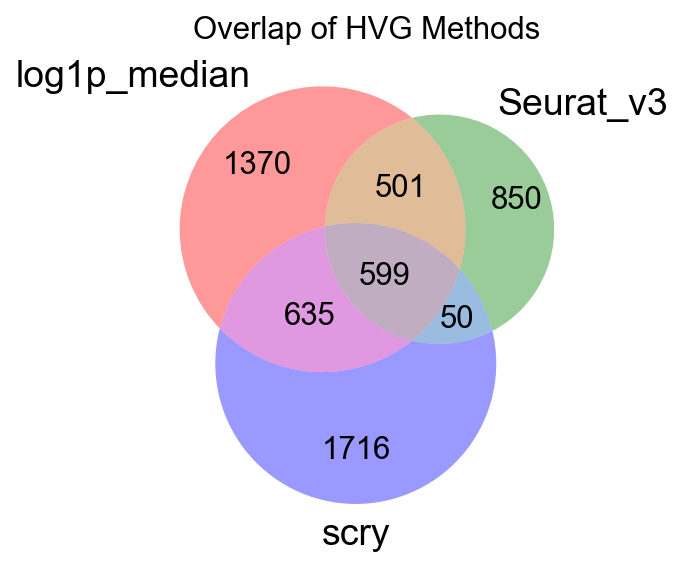

In [238]:
# Plot 3 way Venn Diagrams
venn3([HVG_sets["log1p_median"], 
       HVG_sets["Seurat_v3"], 
       HVG_sets["scry"]], 
       ('log1p_median', 'Seurat_v3', 'scry'))

plt.title("Overlap of HVG Methods")
plt.show();


c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


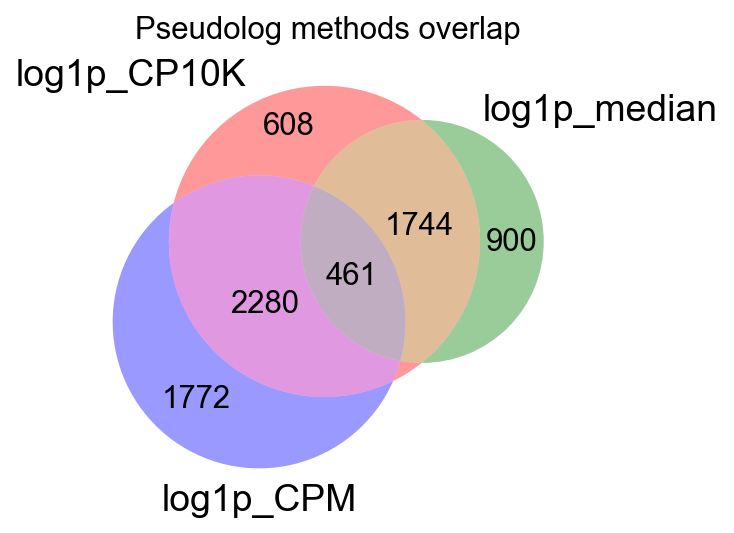

In [239]:
venn3([HVG_sets["log1p_CP10K"], 
       HVG_sets["log1p_median"], 
       HVG_sets["log1p_CPM"]], 
       ('log1p_CP10K', 'log1p_median', 'log1p_CPM'))

plt.title("Pseudolog methods overlap")
plt.show();

The comparison between some arbirtarily chosen methods appears fairly limited. It would be interesting to move forward with the analysis with the genes at the intersection of our various approaches. This will be an approach i will explore in the future, but for an initial pass through, i will stick with the permissive route. 

## Upset Plots

As Venn diagrams quickly stop making sense after 3 groups, we can use an upset plot to explore the intersection between more than 3 methods. 

An upset plot is a method often employed in gene set enrichment analysis to compare sets of genes. It includes a top bar chart showing the sizes of intersections, a bottom matrix indicating which sets are involved in each intersection, and a side bar chart showing the total size of each set. 

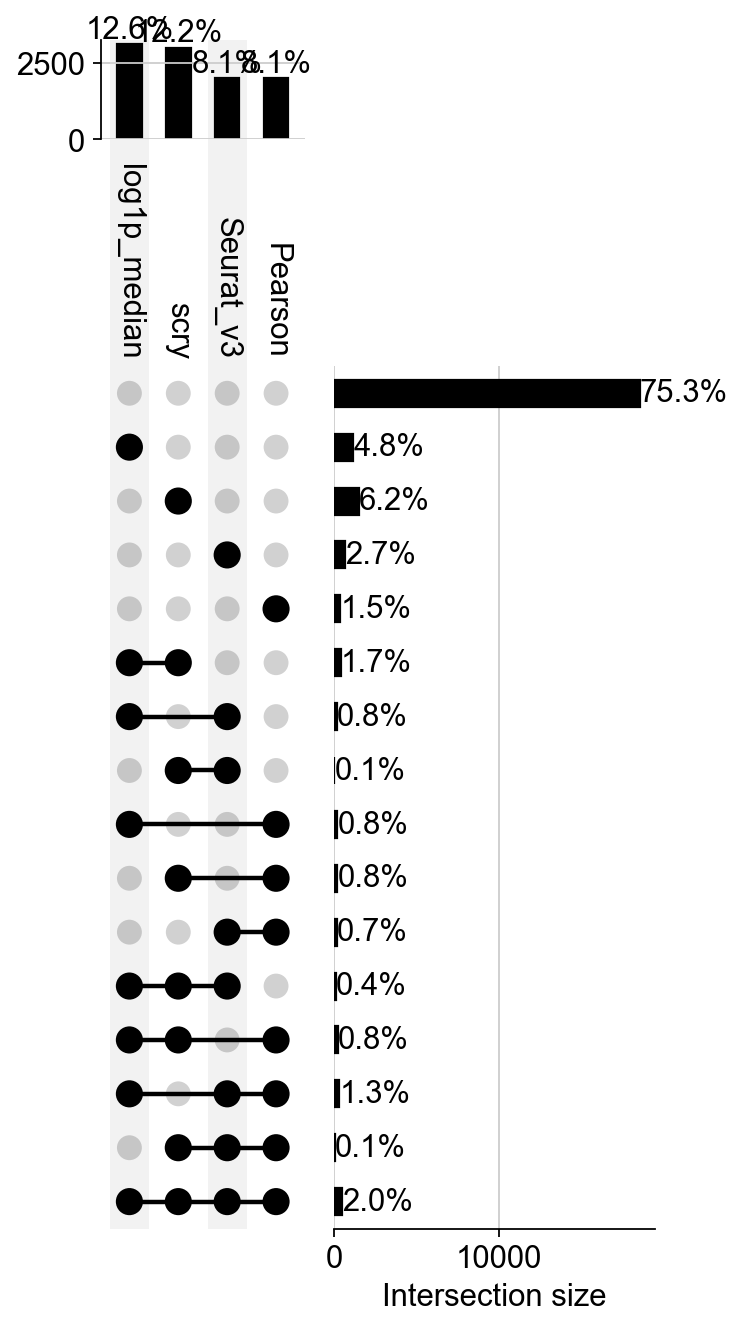

In [240]:
# Combine dataframes, name columns, and create a MultiIndex
multiindex_df = (
    pd.concat(
        [HVG_res_log1p_median['highly_variable'], 
         HVG_res_Seurat_v3['highly_variable'], 
         HVG_res_Pearson_Expt['highly_variable'],
         HDG_scry['highly_deviant']],
         axis=1,
         keys=['log1p_median', 
               'Seurat_v3', 
               'Pearson', 
               'scry']
    )
    .fillna(False)
    .reset_index()
    .set_index(['log1p_median', 
                'Seurat_v3', 
                'Pearson', 
                'scry'])
)

# UpSet plot
upset = UpSet(multiindex_df, show_percentages= True, orientation='vertical')
upset.plot()
plt.show();

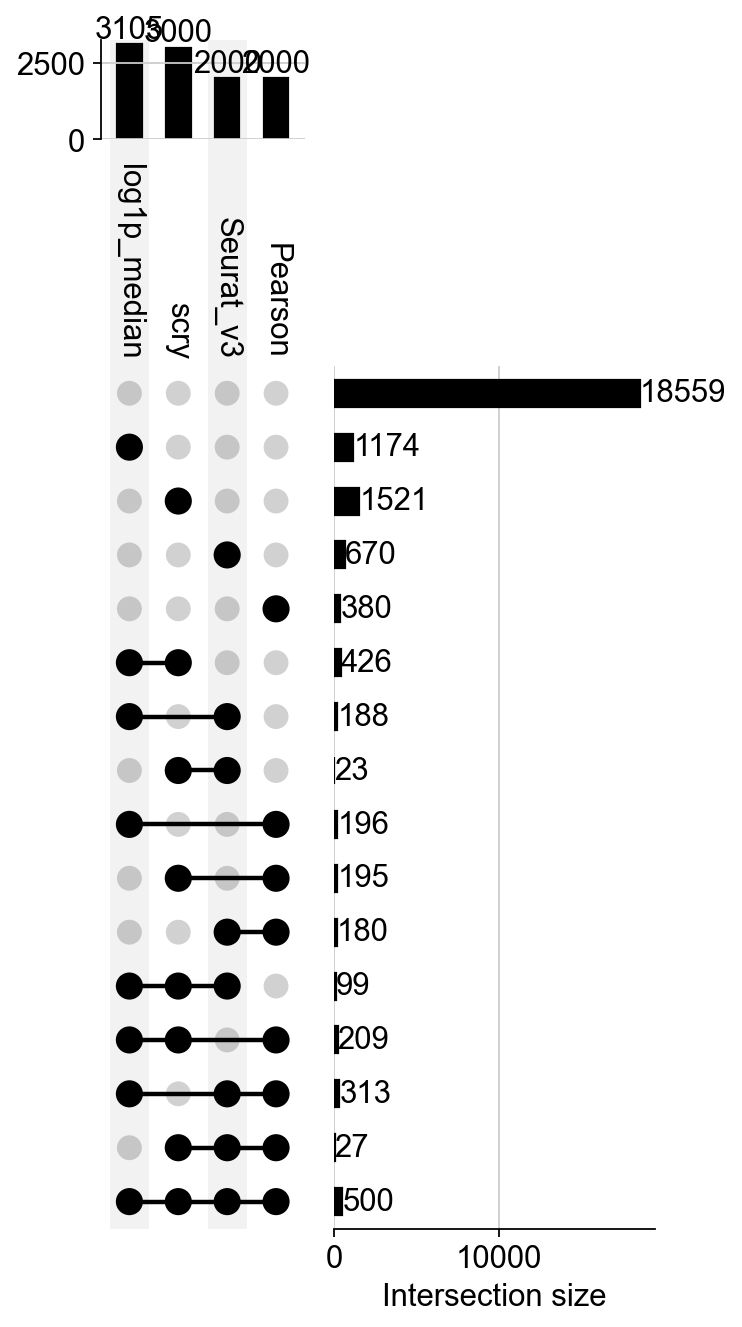

In [241]:
# UpSet plot with counts
upset = UpSet(multiindex_df, show_counts= True, orientation='vertical')
upset.plot()
# plt.gca().set_xscale('log') 
plt.show();

These sections require more exploration, but i am disheartened to find that the various methods for determining highly variable genes are highly...variable...in their findings. There appears to be only a small amount of overlap after checking various permutations. 

The upset plot above shows intersection of genes identified as highly variable across the various methods. The filled in circles indicate the comparisons being made with the bar and precentage indicating the degree of overlap. 

# Filter

Giving consideration to computer memory, we can choose to filter out any genes not identified at highly variable and/or highly deviant. 

If we have CPU/GPU and RAM to spare (or if filters would cause us to loose annonation markers), we may also choose to retain all our genes. Noting that the informative ones are noted as such within out object. 

In [242]:
# # Plot
# sc.pl.highly_variable_genes(adata)

In [243]:
# # Keep only the highly variable genes
# adata = adata[:, adata.var['highly_variable']].copy()
# adata

In [244]:
# # Plot again
# sc.pl.highly_variable_genes(adata)

## Save Object

In [245]:
adata.write("data/C51ctr_HVG.h5ad")

# End Session

In [ ]:
%%R
sessioninfo::session_info()

In [246]:
import session_info
session_info.show()

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\session_info\main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)
